# Mapping Salesforce Leads with folium

In [1]:
# Dependencies
import pandas as pd
import folium
import json
from simple_salesforce import Salesforce
import os.path

# Just for displaying maps on Github
from IPython.display import Image

This script shows how to map Salesforce Lead data which has been extracted with the API.

Create a connection to Salesforce using locally stored credentials in a *json* file with the format:

In [2]:
{"username": "email@domain.co.uk",
"organizationId": "00Aa0000000aBcD",
"password": "mydumbpassword1",
"security_token": "mYseCurItYToken"}

{'organizationId': '00Aa0000000aBcD',
 'password': 'mydumbpassword1',
 'security_token': 'mYseCurItYToken',
 'username': 'email@domain.co.uk'}

In [3]:
# Create API connection to Salesforce

credentials = json.load(open("../../credentials/SF_credentials.json"))

sf = Salesforce(password = credentials["password"], 
                username = credentials["username"], 
                organizationId = credentials["organizationId"],
                security_token = credentials["security_token"])

In [4]:
# Load UK postcodes data and take a look.
postcodes_df = pd.read_csv("./resources/ukpostcodes.csv")
postcodes_df.head()

,id,postcode,latitude,longitude
0,1,AB10 1XG,57.144165,-2.114848
1,2,AB10 6RN,57.137880,-2.121487
2,3,AB10 7JB,57.124274,-2.127190
3,4,AB11 5QN,57.142701,-2.093015
4,5,AB11 6UL,57.137547,-2.112696


In [5]:
# Query Salesforce for all UK Leads with Postcode values stored.
# We're also including some custom price range min/max fields to map the budget of Leads.
# Since the org uses Lead record types we're specifying a record type ID.
# We'll also limit the number of Leads to those received in a 1-year period.
query= """
SELECT Id, PostalCode, Country, Price_Range_min__c, Price_Range_max__c 
FROM Lead
WHERE Country = 'United Kingdom' AND PostalCode != Null
AND RecordTypeId = '012b0000000Dha2'
AND Date_Enquiry_Received__c >= 2016-07-01T00:00:00+00:00
AND Date_Enquiry_Received__c <= 2017-06-30T00:00:00+00:00

"""

leads_df = pd.DataFrame(sf.query_all(query)['records'])
leads_df.drop('attributes',axis=1,inplace=True)
leads_df.tail()

,Id,PostalCode,Country,Price_Range_min__c,Price_Range_max__c
269,00Qb000000PGHGiEAP,sw10,United Kingdom,750001.0,1000000.0
270,00Qb000000ObNIMEA3,SE3 7LG,United Kingdom,0.0,NaN
271,00Qb000000RG7PTEA1,SY8 4DG,United Kingdom,400001.0,500000.0
272,00Qb000000Qo8z9EAB,BS1 1HQ,United Kingdom,0.0,NaN
273,00Qb000000RVifBEAT,SW3 4DJ,United Kingdom,1000001.0,1500000.0


In [6]:
# Now we merge the Salesforce leads with the postcodes file to get the longitude/latitude values.
final_df = pd.merge(leads_df, postcodes_df, how = "inner", left_on = "PostalCode", right_on = "postcode")
final_df.tail()

,Id,PostalCode,Country,Price_Range_min__c,Price_Range_max__c,id,postcode,latitude,longitude
196,00Qb000000PDlUmEAL,KT21 2NR,United Kingdom,500001.0,750000.0,977007,KT21 2NR,51.310223,-0.311053
197,00Qb000000ObNIMEA3,SE3 7LG,United Kingdom,0.0,NaN,382248,SE3 7LG,51.479977,0.014493
198,00Qb000000RG7PTEA1,SY8 4DG,United Kingdom,400001.0,500000.0,221834,SY8 4DG,52.330295,-2.692486
199,00Qb000000Qo8z9EAB,BS1 1HQ,United Kingdom,0.0,NaN,1531232,BS1 1HQ,51.454328,-2.593988
200,00Qb000000RVifBEAT,SW3 4DJ,United Kingdom,1000001.0,1500000.0,241979,SW3 4DJ,51.488679,-0.162111


## Create some maps with folium

### Map 1 - Simple UK map with markers for each Lead

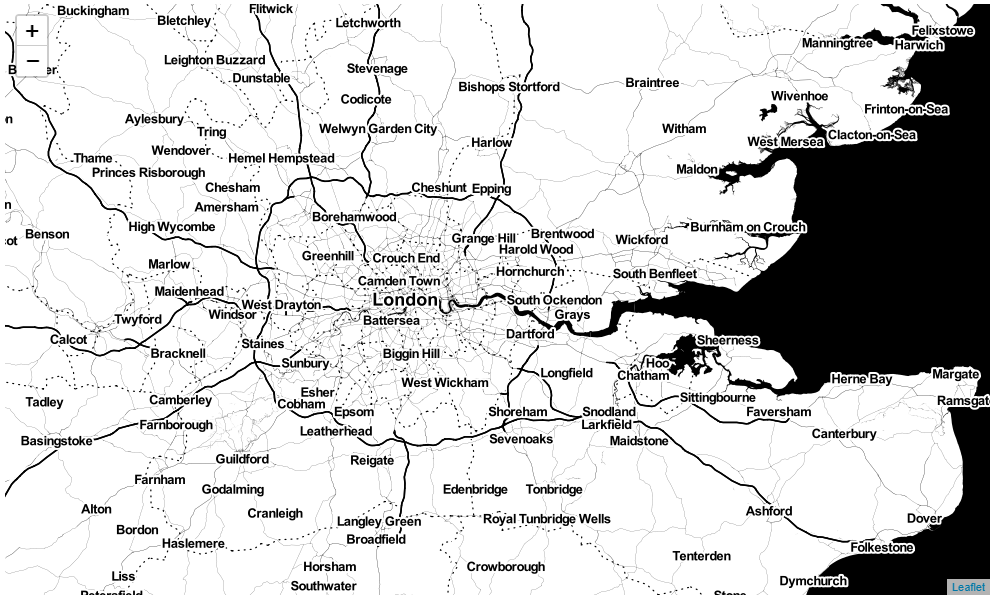

In [7]:
# We start by creating an empty map centred on London.
start_coordinates = (51.5074, 0.1278)
map1 = folium.Map(location = start_coordinates,
                  zoom_start = 9,
                  tiles = 'Stamen Toner')

# Ordinarily in a Jupyter notebook the map can be viewed 
# inline by just calling the variable, e.g.
map1
# However unfortunately this won't render on github, so I've 
# saved an image of the map for display purposes:
Image("./images/map1.PNG")

Next we add markers to show each Lead in the dataframe.

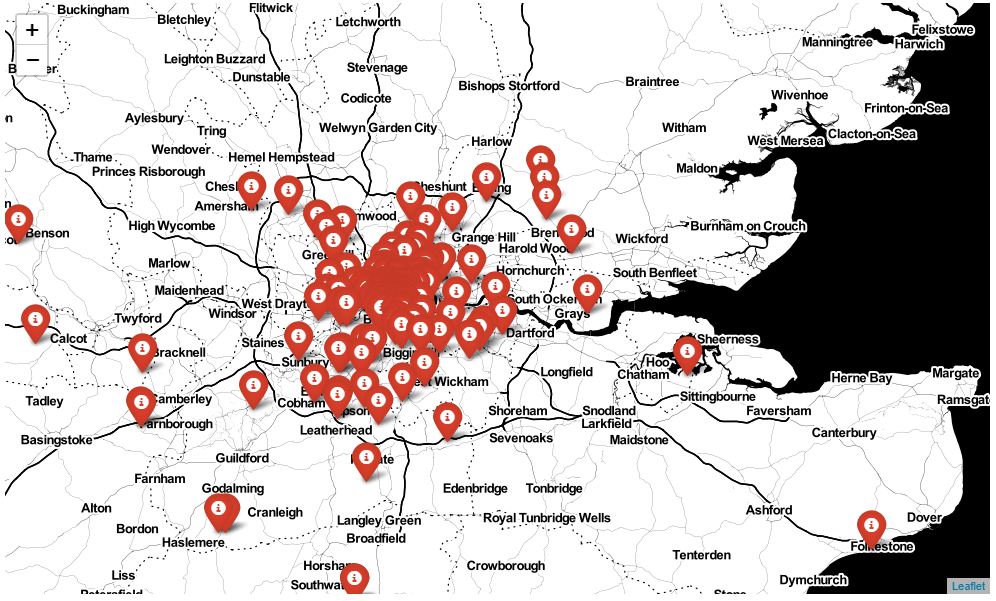

In [8]:
for lead in range (len(final_df)):
    folium.Marker([final_df.latitude[lead],
                   final_df.longitude[lead]],
                   popup = final_df.Id[lead],
                   icon = folium.Icon(color = "red")).add_to(map1)
Image("./images/map1_plus_markers.PNG")

### Map 2 - London map with markers for each Lead & London borough boundaries

Next we'll focus on London and map the Leads along with the London borough boundaries (using GEOJSON files taken from: https://github.com/utisz/compound-cities).

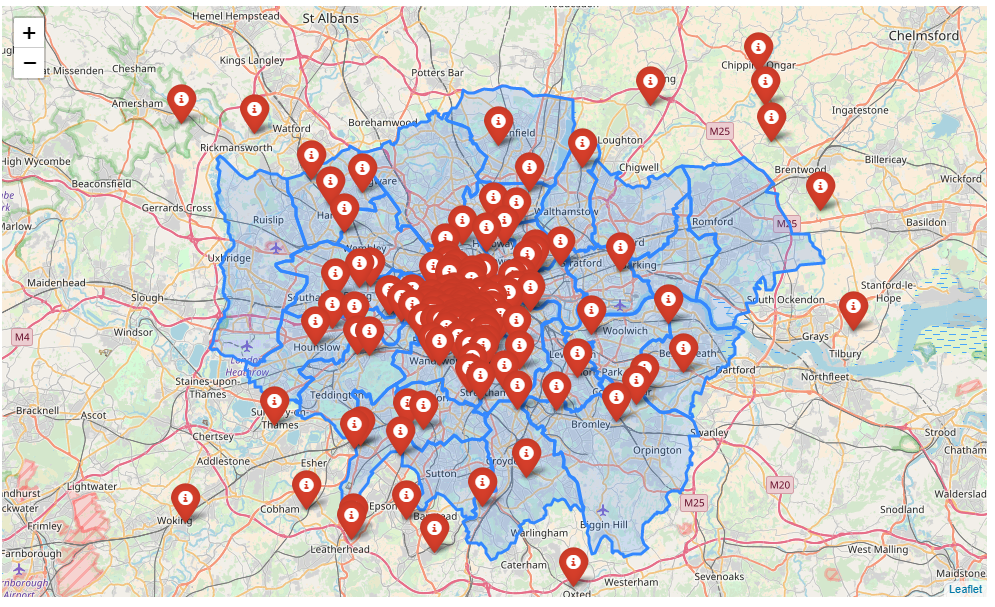

In [9]:
# Overlay the London boroughs

london_coordinates = (51.5074, -0.1178)
map2 = folium.Map(location = london_coordinates,
                  zoom_start = 10,
                  tiles = "OpenStreetMap") # Using a different type of map.

# Add the inner London borough boundaries.
for filename in os.listdir("./resources/inner_london_json/"):
    json_filepath = json.load(open("./resources/inner_london_json/" + filename))
    folium.GeoJson(json_filepath).add_to(map2)

# Add the outer London borough boundaries.
for filename in os.listdir("./resources/outer_london_json/"):
    json_filepath = json.load(open("./resources/outer_london_json/" + filename))
    folium.GeoJson(json_filepath).add_to(map2)

# Add the markers again
for lead in range(len(final_df)):
    folium.Marker([final_df.latitude[lead],
                   final_df.longitude[lead]],
                   popup = final_df.Id[lead],
                   icon = folium.Icon(color = "red")).add_to(map2)
    
Image("./images/map2.PNG")

### Map 3 - London map with markers coloured by budget

Finally, we can zoom in further to Central London, and add colours to the markers based on their budget.

In [10]:
# We need to filter the final_df to just those rows with price range data recorded
price_range_df = final_df.copy()
price_range_df.dropna(axis = 0, subset = [["Price_Range_min__c", "Price_Range_max__c"]], inplace = True)
price_range_df.reset_index(drop = True, inplace = True)

To map budget by colours we need an idea of the distribution of the budgets, based on the *Price_Range_min__c* field. First let's see what the different values in the dataframe are.

In [11]:
print(sorted(list(price_range_df["Price_Range_min__c"].unique())))

[0.0, 400001.0, 500001.0, 750001.0, 1000001.0, 1500001.0, 2000001.0, 2500001.0, 3000001.0, 5000001.0, 10000001.0]


We use matplotlib to see a simple histogram of the distribution of those values in the data.

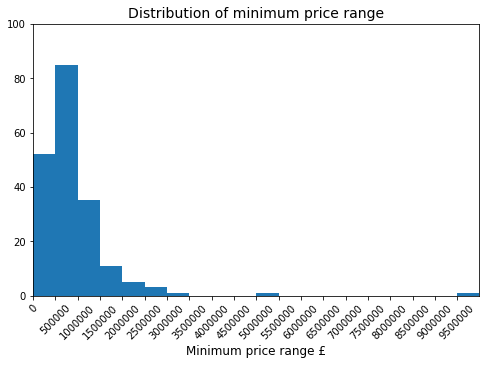

In [12]:
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.figure(figsize = (8,5))
plt.hist(price_range_df["Price_Range_min__c"], bins = 20)
plt.title("Distribution of minimum price range", size = 14)
plt.ylim(0,100)
plt.xlim(0, 10000000)
plt.xticks(range(0,10000000,500000), rotation = 45)
plt.xlabel("Minimum price range £", size = 12)
plt.show()

Based on the distribution of values above, we'll use the following 4 categories for the different colour markers:
* Up to 500,001
* From 500,001 to 1,000,000
* From 1,000,001 to 1,500,000
* 1,500,001 and above

Note that we also add a pop-up which gives the URL link to each individual Lead in Salesforce.

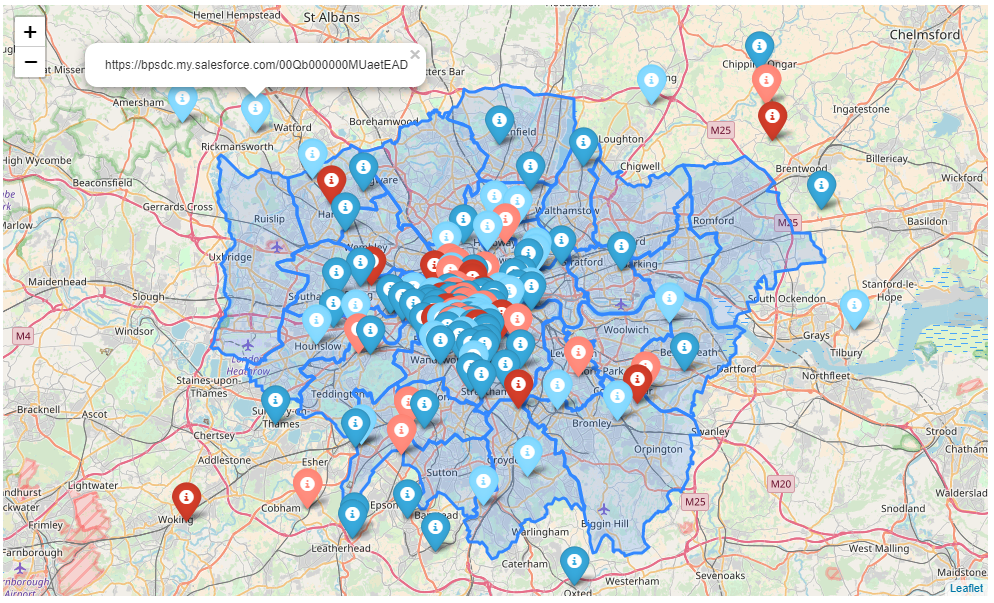

In [13]:
map3 = folium.Map(location = london_coordinates,
                  zoom_start = 10,
                  tiles = "OpenStreetMap")

# Add the inner London borough boundaries.
for filename in os.listdir("./resources/inner_london_json/"):
    json_filepath = json.load(open("./resources/inner_london_json/" + filename))
    folium.GeoJson(json_filepath).add_to(map3)

# Add the outer London borough boundaries.
for filename in os.listdir("./resources/outer_london_json/"):
    json_filepath = json.load(open("./resources/outer_london_json/" + filename))
    folium.GeoJson(json_filepath).add_to(map3)

# Show light blue as lowest budget, to dark red as highest budget.
colours = ["lightblue", "blue", "lightred", "red"] 

# Add the markers
for lead in range(len(price_range_df)):
    
    # Set colour
    price_range = price_range_df.loc[lead, "Price_Range_min__c"]
    if price_range < 500001:
        colour = colours[0]
    elif price_range >= 500001 and price_range <= 1000000:
        colour = colours[1]
    elif price_range >= 1000001 and price_range <= 1500000:
        colour = colours[2]
    else:
        colour = colours[3]
    
    # Popup hyperlink
    popup = "https://bpsdc.my.salesforce.com/{}".format(price_range_df.Id[lead])
    
    # Add marker
    folium.Marker([price_range_df.latitude[lead],
                   price_range_df.longitude[lead]],
                   popup = popup,
                   icon = folium.Icon(color = colour)).add_to(map3)

Image("./images/map3.PNG")

Now we can clearly see that Leads with higher budgets are generally more concentrated in the inner London boroughs!